<a href="https://colab.research.google.com/github/MahlerTom/Siamese-Neural-Networks/blob/master/EX02_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ben-Gurion University of the Negev

Faculty of Engineering Sciences

Department of Software and Information systems Engineering

Introduction to Deep Learning

Assignment 2

# Introduction

In this assignment, we use convolutional neural networks (CNNs) to carry out the task of facial recognition, since CNNs are the current state-of-the-art approach for analyzing imagebased datasets. More specifically, we implement a one-shot classification solution. 
Wikipedia defines one-shot learning as follows:

> “… an object categorization problem, found mostly in computer vision. Whereas most machine learning based object categorization algorithms require training on hundreds or thousands of samples/images and very large datasets, one-shot learning aims to learn information about object categories from one, or only a few, training samples/images.”

Our work is based on the paper [Siamese Neural Networks for One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). Our goal, like that of the paper, is to successfully execute a one-shot learning task for previously unseen objects. Given two facial images of previously unseen persons, our architecture will have to successfully determine whether they are the same person. While we are encouraged to use the architecture described in this paper as a starting point, we shall explore other possibilities as well.

<br>

In this work, we are making use of [`TensorFlow 2.0`](https://www.tensorflow.org/alpha) API on `Google Colab` notebook set on GPU runtime (GPU: 1xTesla K80 , having 2496 CUDA cores, compute 3.7, 12GB (11.439GB Usable) GDDR5 VRAM). We load `TF2.0` as follows:

In [0]:
%%capture
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
# AUTOTUNE = tf.data.experimental.AUTOTUNE

For reproducible results, we init numpy and tensorflow random seed with same values

In [0]:
import numpy as np
np.set_printoptions(precision=2)

from numpy.random import seed
from tensorflow.random import set_seed
seed(2)
set_seed(2)

In [3]:
print('Running on GPU' if tf.test.is_gpu_available() else 'Please change runtime type to GPU on Google Colab under Runtime') # Make sure we are set to GPU (under Runtime->Change runtime type)

Running on GPU


# Analysis of the Dataset 

We use the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/index.html) dataset. Note that there are several versions of this dataset, we use the version found [here](https://talhassner.github.io/home/projects/lfwa/index.html) (it’s called LFW-a, and is also used in the DeepFace paper).

We use the following train and test sets to train your model: [Train](http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt) \ [Test](http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt). We use the test set to perform one-shot learning. This division is set up so that no subject from the test set is included in the train set.

The downloaded directory is built in the following structure:

```
lfw2
│
└───FirstName_LastName1
│   │   FirstName_LastName1_xxx1.jpg
│   │   ...
│   
└───FirstName_LastName2
│   │   FirstName_LastName2_xxx2.jpg
│   │   ...
│   
│   ...
```

Which includes both the train, test, and additional data. Therefore, our first task was to orgenize the data better. We chose to use `python` scripts to create 3 flattened directories: `test`, `train`, and `unused`. For this task, we cannot use additional data for the training, however, we maintain the `unused` directory for potential future work.

Following is the script that we used, which is pretty straight forward:

**Note that you first must download the dataset manually**

## Orgenize dataset

This section explains how we orgenized the dataset. **Note that the orgenized dataset was uploaded to our `GitHub` account:  [MahlerTom/Siamese-Neural-Networks](https://github.com/MahlerTom/Siamese-Neural-Networks), and thus this section can be skipped**

First we download all the necessary files: `pairsDevTrain.txt`, `pairsDevTest.txt`, and 'lfw2.zip', and we unzip the dataset

In [0]:
%%capture
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
!gdown https://drive.google.com/uc?id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp
!unzip lfwa.zip

Next, we define several functions that help us:


1.   The `create_pairs` function helps us create a list of all the names that appear in the `pairsDevTrain.txt` and `pairsDevTest.txt` which we will later use for moving the folders.
2.   The `flatten` function simply flatten a given folder with the specific structure mentioned.
3.   The `move_dirs_and_flatten` function moves a folder from the `src_path` using the `folder_names` list that was created using `create_pairs` into a new folder inside `dst_path` and then flatten it using `flatten`


In [0]:
import shutil
import os

def create_pairs(pairs_path):
  names = set()
  with open(pairs_path) as pairs_path_f:
    pairs_list = pairs_path_f.readlines()[1:]
        
  for pair in pairs_list:
    pair = pair[:-1].split('\t')
    if len(pair) == 3:
      names.add(pair[0])
    elif len(pair) == 4:
      names.add(pair[0])
      names.add(pair[2])
  return list(names)

def flatten(src, verbose=0):
  for directory in os.listdir(src):
    for file in os.listdir(src + directory):
      if verbose > 0:
        print("Moving " + file + "...")
      shutil.move(src + directory + '/' + file, src + file)   

def move_dirs_and_flatten(src_path, dst_path, folders_names, verbose=0):
  for folder_name in folders_names:
    if verbose > 0:
      print("Moving " + folder_name + "...")
    shutil.move(src_path + folder_name, dst_path + folder_name)
  
  flatten(dst_path)

With these functions, we orgenize our dataset into a new folder with the following structure:
```
data
│
└───train
│   │   FirstName_LastName1_xxx1.jpg
│   │   FirstName_LastName2_xxx2.jpg
│   │   ...
│   
└───test
│   │   FirstName_LastName1_xxx1.jpg
│   │   FirstName_LastName2_xxx2.jpg
│   │   ...
│   
└───unused
│   │   FirstName_LastName1_xxx1.jpg
│   │   FirstName_LastName2_xxx2.jpg
│   │   ...
```

In [0]:
import shutil

train_names = create_pairs('pairsDevTrain.txt')
test_names = create_pairs('pairsDevTest.txt')

src = 'lfw2/lfw2/'
move_dirs_and_flatten(src, 'data/train/', train_names)
move_dirs_and_flatten(src, 'data/test/', test_names)
flatten(src)
shutil.move(src, 'data/unused/')
!rm -r lfw2

# Installation

The dataset was uploaded to [MahlerTom/Siamese-Neural-Networks](https://github.com/MahlerTom/Siamese-Neural-Networks), so we first need to clone the repository, with the data. To make things easier, we also define:

*   `repo_path` - the repository path (this should be cross platrform since we use `os` module)
*   `train_path` - the train dataset path
*   `test_path` - the test dataset path

In [0]:
%%capture
import os

# Clone the entire repo.
!git clone -s git://github.com/MahlerTom/Siamese-Neural-Networks.git SiameseNeuralNetworks
repo_path = os.path.join(os.getcwd(), 'SiameseNeuralNetworks')
train_path = os.path.join(repo_path, 'data', 'train')
test_path = os.path.join(repo_path, 'data', 'test')

# Analysis of the Dataset

Before we begin our training, we need to prepare the dataset. Since we are using `TensorFlow 2.0`, we will make use of its functions. We followed the guide at: [https://www.tensorflow.org/alpha/tutorials/load_data/images](https://www.tensorflow.org/alpha/tutorials/load_data/images)

## Preparing the dataset

Before we begin our training, we need to prepare the dataset. Since we are using TensorFlow 2.0, we will make use of its functions. We followed the guide at: [https://www.tensorflow.org/alpha/tutorials/load_data/images](https://www.tensorflow.org/alpha/tutorials/load_data/images)

<br>

Tensorflow makes use of smart functions that can load images given their paths. In addition, we received `trainPairs.txt` and `testPairs.txt`, which include the labels. 

The data structure is as follows: 
```
((left_img_path, right_img_path), label)
```

Thus, the following `load_data` function will create it.

Loaded 6685 image paths
##########################################
Printing Example Images



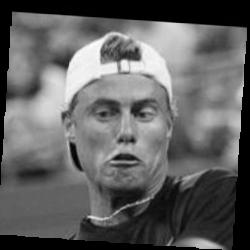

Lleyton_Hewitt_0033



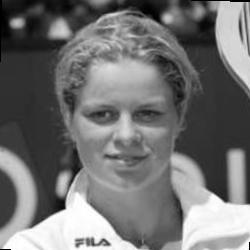

Kim_Clijsters_0004



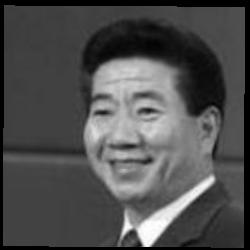

Roh_Moo-hyun_0020

##########################################
Loaded 2741 image paths
##########################################
Printing Example Images



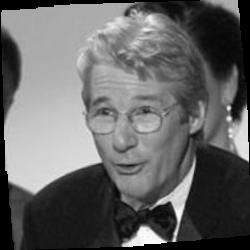

Richard_Gere_0007



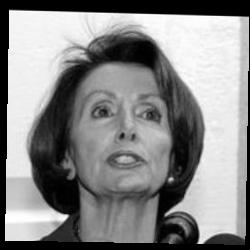

Nancy_Pelosi_0002



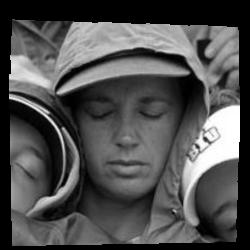

Allison_Searing_0001

##########################################


In [8]:
from SiameseNeuralNetworks.data import load_data

# Utility array to print the name of the label easily (tested on Google Colab)
label_name = ['Different', 'Same']

train_paths_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'trainPairs.txt'), print_imgs=3)
test_paths_labels = load_data(test_path, labels_file=os.path.join(repo_path, 'testPairs.txt'), print_imgs=3)

The images are grayscale with resolution $250\times250$.

In [9]:
from SiameseNeuralNetworks.utils import print_dataset_stat

print_dataset_stat(train_paths_labels, ds_name='Train')
print('############\n\n############')
print_dataset_stat(test_paths_labels, ds_name='Test')

Examples for Train dataset structure:
############
Raw view:
[('/content/SiameseNeuralNetworks/data/train/Aaron_Peirsol_0001.jpg', '/content/SiameseNeuralNetworks/data/train/Aaron_Peirsol_0002.jpg', 1), ('/content/SiameseNeuralNetworks/data/train/Aaron_Peirsol_0003.jpg', '/content/SiameseNeuralNetworks/data/train/Aaron_Peirsol_0004.jpg', 1), ('/content/SiameseNeuralNetworks/data/train/Aaron_Sorkin_0001.jpg', '/content/SiameseNeuralNetworks/data/train/Aaron_Sorkin_0002.jpg', 1)]
############
Pretty view:
[('Aaron_Peirsol_0001', 'Aaron_Peirsol_0002', 'Same'), ('Aaron_Peirsol_0003', 'Aaron_Peirsol_0004', 'Same'), ('Aaron_Sorkin_0001', 'Aaron_Sorkin_0002', 'Same')]
############
Dataset size: 2200
2 classes:
+-----------+-----------+------------+
|   Class   |    Size   | Percentage |
+-----------+-----------+------------+
| Different | 1100/2200 |   50.00%   |
|    Same   | 1100/2200 |   50.00%   |
+-----------+-----------+------------+
############

############
Examples for Test dataset 

## Create Validation Set

It is often a recommended to use a validation set when training the model; thus, we have chosen to use a 70-30 train-validation ratio. It's important to note that while we are guarenteed that their is no subject from the test set included in the train set, we do not have this guarentee for the train-validation separation. Therefore, if we randomly choose a 70-30 separation ratio (a common choice), we will likely have subjects included in both the training and validation sets, which will cause a problems.

Therefore, we explore separating the sets based on the persons name, to guarentee the sets are independent.

As we can see, if we choose the letters: `'A'`, `'B'`, `'C'`, `'D'`, `'E'` for the 'same' validation set, and the leters: `'A'`, `'B'`, `'C'` for the 'different' validation set, we will get:


In [10]:
from SiameseNeuralNetworks.utils import explore_subject_names
from SiameseNeuralNetworks.data import image_name

from prettytable import PrettyTable

train_same = [image_name(p[0]) for p in train_paths_labels[:1100]]
train_diff = [image_name(p[0]) for p in train_paths_labels[1100:]]
h_same = explore_subject_names(train_same)
h_diff = explore_subject_names(train_diff)

t = PrettyTable([''] + list(h_same.keys()))
t.add_row(['Same'] + list(h_same.values()))
t.add_row(['Different'] + list(h_diff.values()))
print(t)
print()

letters_selected_same = h_same['A'] + h_same['B'] + h_same['C'] + h_same['D'] + h_same['E']
letters_selected_different = h_diff['A'] + h_diff['B'] + h_diff['C']

t = PrettyTable(['', 'Total Size', 'Chosen Letters', 'Chosen Letters Size', 'Percentage'])
t.add_row(['Same', sum(h_same.values()), 'A, B, C, D, E', letters_selected_same, f'{letters_selected_same/len(train_same)*100:.2f}%'])
t.add_row(['Different', sum(h_diff.values()), 'A, B, C', letters_selected_different, f'{letters_selected_different/len(train_diff)*100:.2f}%'])
t.add_row(['All', sum(h_same.values()) + sum(h_diff.values()), 'A-Z', letters_selected_same + letters_selected_different,  f'{(letters_selected_same + letters_selected_different)/(len(train_same) + len(train_diff))*100:.2f}%'])
print(t)

+-----------+-----+-----+-----+-----+----+----+----+----+----+-----+----+----+-----+----+---+----+---+----+----+----+---+----+----+---+----+---+
|           |  A  |  B  |  C  |  D  | E  | F  | G  | H  | I  |  J  | K  | L  |  M  | N  | O | P  | Q | R  | S  | T  | U | V  | W  | X | Y  | Z |
+-----------+-----+-----+-----+-----+----+----+----+----+----+-----+----+----+-----+----+---+----+---+----+----+----+---+----+----+---+----+---+
|    Same   | 101 |  59 |  80 |  58 | 45 | 20 | 50 | 42 | 9  | 145 | 29 | 41 | 102 | 25 | 4 | 46 | 7 | 74 | 62 | 45 | 1 | 16 | 17 | 3 | 13 | 6 |
| Different | 144 | 121 | 114 | 103 | 64 | 31 | 62 | 47 | 16 | 151 | 34 | 40 |  63 | 22 | 1 | 34 | 2 | 20 | 21 | 8  | 0 | 1  | 1  | 0 | 0  | 0 |
+-----------+-----+-----+-----+-----+----+----+----+----+----+-----+----+----+-----+----+---+----+---+----+----+----+---+----+----+---+----+---+

+-----------+------------+----------------+---------------------+------------+
|           | Total Size | Chosen Letters | Chosen

Which provides a good separation. The following function splits the train to train and validation based on the chosen letters:

In [11]:
from SiameseNeuralNetworks.data import split_train_val_paths

train_same, val_same = split_train_val_paths(train_paths_labels[:1100], letters='ABCDE')
train_diff, val_diff = split_train_val_paths(train_paths_labels[1100:], letters='ABC')
train_paths_labels_split = train_same + train_diff
val_paths_labels_split = val_same + val_diff

t = PrettyTable(['', 'Size', 'Percentage'])
t.add_row(['Train Same', f'{len(train_same)}/{len(train_paths_labels)}', f'{len(train_same)/len(train_paths_labels)*100:.2f}%'])
t.add_row(['Train Different', f'{len(train_diff)}/{len(train_paths_labels)}', f'{len(train_diff)/len(train_paths_labels)*100:.2f}%'])
t.add_row(['Train', f'{len(train_paths_labels_split)}/{len(train_paths_labels)}', f'{len(train_paths_labels_split)/len(train_paths_labels)*100:.2f}%'])
t.add_row(['', '', ''])
t.add_row(['Validation Same', f'{len(val_same)}/{len(train_paths_labels)}', f'{len(val_same)/len(train_paths_labels)*100:.2f}%'])
t.add_row(['Validation Different', f'{len(val_diff)}/{len(train_paths_labels)}', f'{len(val_diff)/len(train_paths_labels)*100:.2f}%'])
t.add_row(['Validation', f'{len(val_paths_labels_split)}/{len(train_paths_labels)}', f'{len(val_paths_labels_split)/len(train_paths_labels)*100:.2f}%'])
print(t)

+----------------------+-----------+------------+
|                      |    Size   | Percentage |
+----------------------+-----------+------------+
|      Train Same      |  757/2200 |   34.41%   |
|   Train Different    |  721/2200 |   32.77%   |
|        Train         | 1478/2200 |   67.18%   |
|                      |           |            |
|   Validation Same    |  343/2200 |   15.59%   |
| Validation Different |  379/2200 |   17.23%   |
|      Validation      |  722/2200 |   32.82%   |
+----------------------+-----------+------------+




* A training set of 757 'same' and 721 'different', and a total of  $ 1478 / 2200 = 67.1\% $.
* A validation set of 343 'same' and 379 'different', and a total of  $ 722 / 2200 = 32.8\% $.

The *same* validation set includes all subjects with name 

The reason for this specific choice, is that while we are guarenteed that their is no subject from the test set included in the train set, we do not have this guarentee for the train-validation separation. Therefore, if we randomly choose a 70-30 train-validation separation (a common choice), we will likely have validation subjects included in the training set, which will cause a problems.


<br>

Make your own decision whether to use one and what percentage of (training) samples to allocate.

Also provide the full experimental setup you used -- batch sizes, the various parameters of your architecture, stopping criteria and any other
relevant information. A good rule of thumb: if asked to recreate your work, a person should be able to do so based on the information you provide in your report.

# Data Statistics

In your report, include an analysis of the dataset (size, number of examples – in total and per class – for the train and test sets, etc).

Also provide the full experimental setup you used – batch sizes, the various parameters of your architecture, stopping criteria and any other relevant information. 

A good rule of thumb: if asked to recreate your work, a person should be able to do so based on the information you provide in your report.

In this project, we have 

Download the dataset. Note: there are several versions of this dataset, use the version
found here (it’s called LFW-a, and is also used in the DeepFace paper).

# Methods

## Network Architecture

We implemented the Siamese neural network for this task. Before implementing the network, we resized the input images from size of $250 * 250$ to $125 * 125$.

We start with the exactly same network architecture as in [this paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). Generally, the network is composed of two identical convolutional neural networks, which are connected to one fully connected layers. Each CNN is composed of 4 convolutional layers, each of which uses a single channel filters with various size and fixed stride of 1. The network applies a ReLU activation function to the output feature maps, followed by maxpooling with a ﬁlter size and stride of 2. The units in the ﬁnal convolutional layer are ﬂattened into a single vector. This convolutional layer is followed by a fully-connected layer, and then one more layer computing the L1 distance metric between the output of both siamese twins, which is given to a single sigmoidal output unit. 

The originial network architecture performs poorly on our task. Assuming that the reason was too many parameters, we reduced the number of filters and the adjusted filter sizes. We tried different network settings and made our decision based on the performance on validation dataset, attempts including: 
* changing number of filters and filter size
    * Number of filters: 4, 8, 16
    * Filter size: $2*2$ to $12 * 12$
* changing size of the fully connected layers
    * 1024 to 4096
* Weight initialization method
    * $N(0, 10^{-2})$
    * Glorot (Xavier) normal
    * LeCun normal
* Loss function
    * Binary cross-entropy
    * Contrastive loss
        
Changing the loss function to contrastive loss requires some modifications in the network architecture. According to the loss function:

$Y\frac12(D_w)^2 + (1-Y)\frac12\{max(margin-D_w, 0)\}^2$

where $Y=1$ for true class (images are of same people) and 0 vice versa, and $D_w$ is expected to be the euclidean distance of the two feature maps of the input image pairs, we remove the final sigmoidal layer of the network, changing the distance mersurement from L1 to euclidean, and used the distance directly as the output of our network. 

Eventually, we achieved our best results with the following network architecture:
* Number of CNN layers: 4
* Number of filters: 8, 16, 32, 64
* Filter size: $10*10, 7*7, 4*4, 4*4$
* Size of fully connected layer: 2048
* Weight initialization method: $N(0, 10^{-2})$
* Bias Initialization method: normal distribution $N(0.5, 10^{-2})$
* Loss function: binary cross-entropy

## Evaluation Methods

In this section we explain the evaluation methods we shall use to measure the performance of our architecture. 

### Hyper-parameters tuning

We use hyper-parameters tuning in order to choose the best configuration for our network. There are numerous parameters that affect the performance of the network, and we shall focus on the following parameters: resizing the images, batch size, number of filters, number of units in the last layer, optimizer, and learning rate.

As we explained in the methods section, we have implemented the based on **[TODO]**. In each layer convolutional layer, we define a different number of filters, so that the next layer has twice the number of filters as the previous layer. The original network includes 64, 128, 256, and 512 filters in the convolutional layers, and 4096 units in the last layer. This results in a very large and deep network, that takes too long to run (and doesn't necessarily output better results). Therefore, we define a configurable filter size, while keeping the proportions between the layers, and a configurable unit size for the last layer. As part of our evaluation, we shall try different filter and unit size to check the effect on the performance.

In addition, we measure the effects of resizing the image. Intuitively, higher resolution ($250\times 250$) should result in more details, making the network learn deeper insights. However, for many tasks smaller resulotions are good enough. We will try to resize the network to $125\times 125$ and see test the performance.

Finally, the learning rate, batch size, and optimizer, has a significant effect on the training, so we shall test them as well.

### Early Stopping and Model Checkpoint

To avoid overfitting, and running for too many epochs, we use early stopping. Early stopping means that we train the model while monitoring the validation loss. When we see that the validation loss stops decreasing we stop the training process. We apply `patience` of three, which means that we monitor the loss and stop only when it hasn't decreased for at least three epochs. The model checkpoint callback helps us save only the best weights even of the loss increased. 

### Loss and other metrics

We use binary crossentropy loss and the contrastive loss while monitoring the accuracy. We note that, as we explained in the data section, we split the training set into 70% training set and 30% validation set. In all our experiments, we evaluate our model on the validation and the test set.